# Ray Core: Image Transformation

## Introduction

This notebook demonstrates image transformations performed both serially and in parallel using Ray. The original version of this example can be found in the Ray Educational Materials project, specifically in the [Ray Core 1 - Remote Functions](https://github.com/ray-project/ray-educational-materials/blob/main/Ray_Core/Ray_Core_1_Remote_Functions.ipynb) notebook.

The notebook starts by downloading images and storing them in the `IMAGES_DIR` directory. If the directory is not empty, the download is skipped.

The images are transformed both serially and in a distributed manner using Ray, first in a local cluster, then in a remote (and more powerful) one. All executions are measured to compare their performance.

In [1]:
import os
import random
import time

import boto3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import requests
import torch

In [2]:
from dotenv import load_dotenv
from ray_demo.utils.constants import ROOT_DIR, IMAGE_URLS, DATA_DIR

load_dotenv(ROOT_DIR / ".env")

True

In [ ]:
# os.environ["AWS_PROFILE"] = "<your AWS profile>" # Update accordingly
# os.environ["RAY_ADDRESS"] = "http://<head-node-public-ip>:8265/" # Update accordingly

In [3]:
USE_S3 = False
S3_BUCKET = "ray-demo-data"
S3_PREFIX = "ray-core-images"

IMAGES_DIR = DATA_DIR / "ray-core-images"
IMAGES_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
def download_images(url: str, data_dir: str) -> None:
    """
    Given a URL and the image data directory, fetch the URL and save it in the data directory
    """
    img_data = requests.get(url).content
    img_name = url.split("/")[4]
    img_name = f"{data_dir}/{img_name}.jpg"
    with open(img_name, "wb+") as f:
        f.write(img_data)


def upload_images_to_s3(data_dir: str, bucket: str, prefix: str) -> None:
    """
    Uploads images from a local directory to an S3 bucket.

    Args:
        data_dir (str): The local directory path where the images are located.
        bucket (str): The name of the S3 bucket.
        prefix (str): The prefix to be added to the S3 object key.

    Returns:
        None
    """
    image_paths = []
    s3 = boto3.client("s3")
    for img_file in os.listdir(data_dir):
        if img_file.endswith(".jpg"):
            local_path = os.path.join(data_dir, img_file)
            s3_path = os.path.join(prefix, img_file)
            image_paths.append(s3_path)
            s3.upload_file(local_path, bucket, s3_path)

In [5]:
if len(os.listdir(IMAGES_DIR)) == 0:
    print(f"downloading images ...")
    for url in IMAGE_URLS:
        download_images(url, IMAGES_DIR)
else:
    print(f"Images dir is not empty, skipping download ...")

Images dir is not empty, skipping download ...


In [6]:
if not USE_S3:
    image_list = list(IMAGES_DIR.glob("*.jpg"))
else:
    image_list = upload_images_to_s3(IMAGES_DIR, S3_BUCKET, S3_PREFIX)

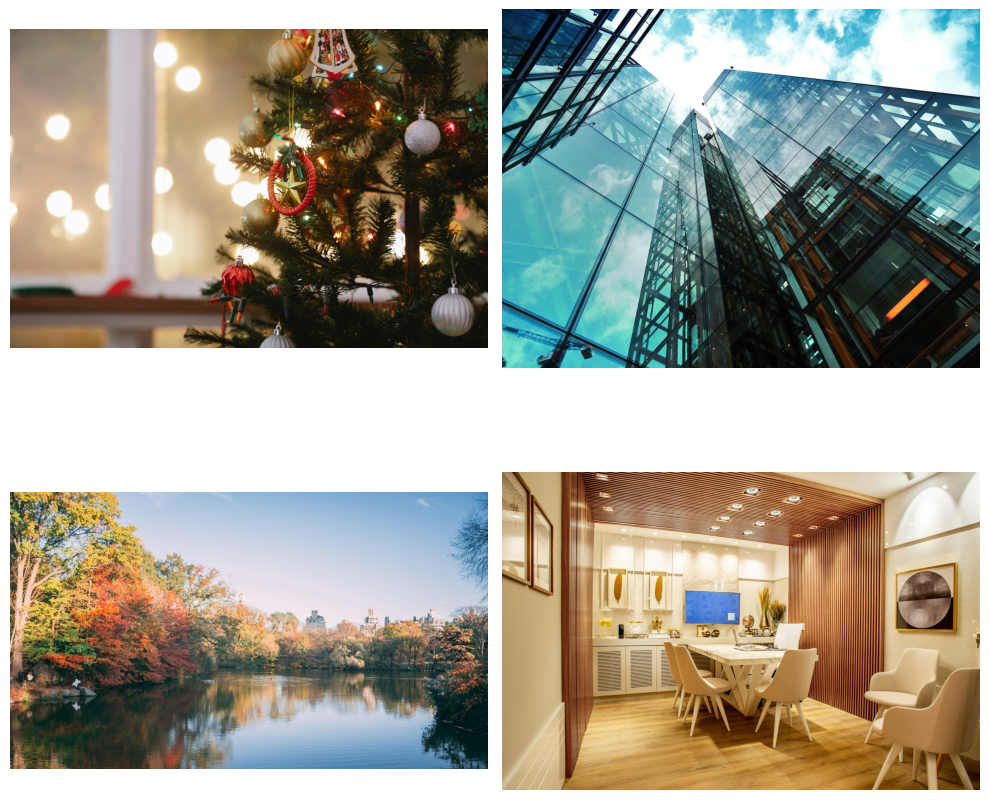

In [7]:
random_images = random.sample(image_list, 4)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    img = plt.imread(random_images[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Ray (local cluster)

In [8]:
if ray.is_initialized():
    ray.shutdown()

ray.init(address="local")

2024-08-11 23:22:19,073	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.9
Ray version:,2.30.0
Dashboard:,http://127.0.0.1:8265


Populate the Ray Object Store

In [9]:
from PIL import Image


image_refs = []

if USE_S3:
    s3 = boto3.client("s3")

    paginator = s3.get_paginator("list_objects_v2")
    for result in paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX):
        for i, content in enumerate(result.get("Contents", [])):
            image = s3.get_object(Bucket=S3_BUCKET, Key=content["Key"])
            img = Image.open(image["Body"])
            img_ref = ray.put(img)
            if i % 5 == 0:
                print(f"Image reference: {img_ref}")
            image_refs.append(img_ref)
else:
    for i, img_name in enumerate(image_list):
        img = Image.open(img_name)
        img_ref = ray.put(img)
        if i % 5 == 0:
            print(f"Image reference: {img_ref}")
        image_refs.append(img_ref)

Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000001e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000006e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000000be1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000010e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000015e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000001ae1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000001fe1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000024e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000029e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff010000002ee1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffffff0100000033e1f505)
Image reference: ObjectRef(00ffffffffffffffffffffffffffffffffffff

(raylet) Spilled 4243 MiB, 88 objects, write throughput 547 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(raylet) Spilled 4961 MiB, 99 objects, write throughput 308 MiB/s.


In [10]:
BATCHES = [10, 20, 30, 40, 50]
SERIAL_BATCH_TIMES = []
DISTRIBUTED_BATCH_TIMES = []
THUMB_SIZE = (64, 64)

In [11]:
from PIL import ImageFilter
from torchvision.transforms import v2 as T


def transform_image(img_ref:object, fetch_image=True, verbose=False):
    """
    This is a deliberate compute intensive image transfromation and tensor operation
    to simulate a compute intensive image processing
    """
    import ray

    # Only fetch the image from the object store if called serially.
    if fetch_image:
        img = ray.get(img_ref)
    else:
        img = img_ref
    before_shape = img.size

    # Make the image blur with specified intensify
    # Use torchvision transformation to augment the image
    img = img.filter(ImageFilter.GaussianBlur(radius=20))

    augmentor = T.TrivialAugmentWide(num_magnitude_bins=31)
    img = augmentor(img)

    # Convert image to tensor and transpose
    tensor = torch.tensor(np.asarray(img))
    t_tensor = torch.transpose(tensor, 0, 1)

    # compute intensive operations on tensors
    random.seed(42)
    for _ in range(3):
        tensor.pow(3).sum()
        t_tensor.pow(3).sum()
        torch.mul(tensor, random.randint(2, 10))
        torch.mul(t_tensor, random.randint(2, 10))
        torch.mul(tensor, tensor)
        torch.mul(t_tensor, t_tensor)

    # Resize to a thumbnail
    img.thumbnail(THUMB_SIZE)
    after_shape = img.size
    if verbose:
        print(f"augmented: shape:{img.size}| image tensor shape:{tensor.size()} transpose shape:{t_tensor.size()}")

    return before_shape, after_shape

In [12]:
from typing import List, Tuple


@ray.remote
def augment_image_distributed(image_ref: object, fetch_image) -> List[object]:
    return transform_image(image_ref, fetch_image=fetch_image)

In [18]:
# Define a function to run these transformation tasks serially, on a single node, single core
def run_serially(img_list_refs: List) -> List[Tuple[int, float]]:
    """
    Runs image transformation serially on a list of image references.
    Args:
        img_list_refs (List): A list of image references.
    Returns:
        List[Tuple[int, float]]: A list of tuples containing the transformed image results.
            Each tuple consists of an integer representing the image reference and a float
            representing the transformation result.
    """
    transform_results = [
        transform_image(img_ref=image_ref, fetch_image=True)
        for image_ref in img_list_refs
    ]
    return transform_results


def run_distributed(img_list_refs: List) -> List[Tuple[int, float]]:
    """
    Runs image processing tasks in a distributed manner using Ray.
    Args:
        img_list_refs (List): A list of image references.
    Returns:
        List[Tuple[int, float]]: A list of tuples containing the image ID and processing time.
    """
    return ray.get(
        [
            augment_image_distributed.remote(image_ref=img, fetch_image=False)
            for img in img_list_refs
        ]
    )

In [16]:
for idx in BATCHES:
    # Use the index to get N number of URLs to images
    image_batch_list_refs = image_refs[:idx]
    print(f"\nRunning {len(image_batch_list_refs)} tasks serially....")

    start = time.perf_counter()
    serial_results = run_serially(image_batch_list_refs)
    end = time.perf_counter()
    elapsed = end - start
    
    SERIAL_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Serial transformations/computations of {len(image_batch_list_refs)} images: {elapsed:.2f} sec")


Running 10 tasks serially....
Serial transformations/computations of 10 images: 9.06 sec

Running 20 tasks serially....
Serial transformations/computations of 20 images: 19.84 sec

Running 30 tasks serially....
Serial transformations/computations of 30 images: 27.19 sec

Running 40 tasks serially....
Serial transformations/computations of 40 images: 40.60 sec

Running 50 tasks serially....
Serial transformations/computations of 50 images: 45.38 sec


### Distributed Execution

In [19]:
# Iterate over batches, launching Ray task for each image within the processing
# batch
for idx in BATCHES:
    image_batch_list_refs = image_refs[:idx]
    print(f"\nRunning {len(image_batch_list_refs)} tasks distributed....")
    
    # Run each one serially
    start = time.perf_counter()
    distributed_results = run_distributed(image_batch_list_refs)
    end = time.perf_counter()
    elapsed = end - start

     # Keep track of batchs, execution times as a Tuple
    DISTRIBUTED_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Distributed transformations/computations of {len(image_batch_list_refs)} images: {elapsed:.2f} sec")


Running 10 tasks distributed....
Distributed transformations/computations of 10 images: 13.61 sec

Running 20 tasks distributed....
Distributed transformations/computations of 20 images: 25.24 sec

Running 30 tasks distributed....
Distributed transformations/computations of 30 images: 40.39 sec

Running 40 tasks distributed....
Distributed transformations/computations of 40 images: 56.32 sec

Running 50 tasks distributed....
Distributed transformations/computations of 50 images: 60.79 sec


### Compare Results

In [20]:
def extract_times(lst: Tuple[int, float]) -> List[float]:
    """
    Given a list of Tuples[batch_size, execution_time] extract the latter
    """
    times = [t[1] for t in lst]
    return times


def plot_times(batches: List[int], s_lst: List[float], d_lst: List[float]) -> None:
    """
    Plot the execution times for serail vs distributed for each respective batch size of images
    """
    s_times = extract_times(s_lst)
    d_times = extract_times(d_lst)
    data = {"batches": batches, "serial": s_times, "distributed": d_times}

    df = pd.DataFrame(data)
    df.plot(x="batches", y=["serial", "distributed"], kind="bar")
    plt.ylabel("Times in sec", fontsize=12)
    plt.xlabel("Number of Batches of Images", fontsize=12)
    plt.grid(False)
    plt.show()

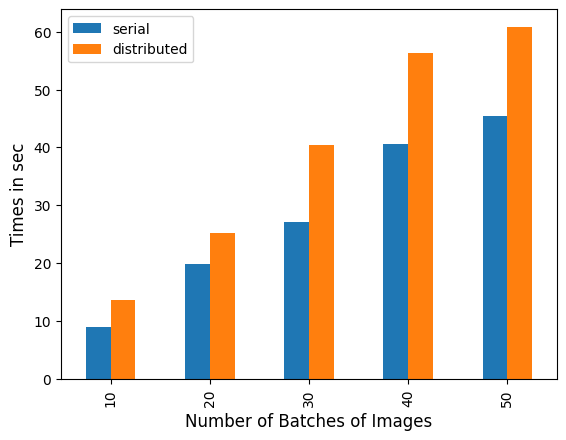

In [21]:
plot_times(BATCHES, SERIAL_BATCH_TIMES, DISTRIBUTED_BATCH_TIMES)

## Ray (remote cluster)

In [23]:
# if ray.is_initialized():
#     ray.shutdown()

os.environ["RAY_ADDRESS"] = "ray://54.242.33.23:10001"

ray.init()

2024-08-11 23:43:35,861	INFO worker.py:1445 -- Using address ray://54.242.33.23:10001 set in the environment variable RAY_ADDRESS
SIGTERM handler is not set because current thread is not the main thread.


Python version:,3.11.9
Ray version:,2.30.0
Dashboard:,http://10.0.1.184:8265


In [ ]:
image_refs_remote = []
for i, img_name in enumerate(image_list):
    img = Image.open(img_name)
    img_ref = ray.put(img)
    if i % 5 == 0:
        print(f"Image reference: {img_ref}")
    image_refs_remote.append(img_ref)

In [24]:
DISTRIBUTED_REMOTE_BATCH_TIMES = []

# Iterate over batches, launching Ray task for each image within the processing
# batch
for idx in BATCHES:
    image_batch_list_refs = image_refs[:idx]
    print(f"\nRunning {len(image_batch_list_refs)} tasks distributed....")
    
    # Run each one serially
    start = time.perf_counter()
    distributed_results = run_distributed(image_batch_list_refs)
    end = time.perf_counter()
    elapsed = end - start

     # Keep track of batchs, execution times as a Tuple
    DISTRIBUTED_REMOTE_BATCH_TIMES.append((idx, round(elapsed, 2)))
    print(f"Distributed transformations/computations of {len(image_batch_list_refs)} images: {elapsed:.2f} sec")


Running 10 tasks distributed....


RayTaskError(OwnerDiedError): [36mray::augment_image_distributed()[39m (pid=527, ip=10.0.1.184)
  At least one of the input arguments for this task could not be computed:
ray.exceptions.OwnerDiedError: Failed to retrieve object 00ffffffffffffffffffffffffffffffffffffff0100000002e1f505. To see information about where this ObjectRef was created in Python, set the environment variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init()`.

The object's owner has exited. This is the Python worker that first created the ObjectRef via `.remote()` or `ray.put()`. Check cluster logs (`/tmp/ray/session_latest/logs/*01000000ffffffffffffffffffffffffffffffffffffffffffffffff*` at IP address 127.0.0.1) for more information about the Python worker failure.

In [ ]:
plot_times(BATCHES, SERIAL_BATCH_TIMES, DISTRIBUTED_BATCH_TIMES)